# 5회차 실습 과제

## 문제 항목

| 문제     | 주제                                       | 핵심 학습 포인트                              |
|----------|--------------------------------------------|-----------------------------------------------|
| 문제 1   | 3개 공장의 배터리 수명 비교 (ANOVA)        | 가정 검정 → 검정 선택 → 사후검정 → 효과크기   |
| 문제 2   | 직원 데이터 상관분석                       | Pearson vs Spearman, 산점도, 상관 vs 인과      |
| 문제 3   | 앱 UI 변경 A/B 테스트 (전환율)             | 실험 설계 → 표본 크기 산정 → 검정 → 의사결정   |
| 문제 4   | 학습 앱 A/B 테스트 (연속형 지표)           | 연속형 A/B 테스트, CLT, 모수 vs 비모수         |

In [1]:
# 필수 라이브러리 Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from itertools import combinations
import pingouin as pg
import scikit_posthocs as sp
from statsmodels.stats.proportion import proportions_ztest, proportion_effectsize, proportion_confint, confint_proportions_2indep
from statsmodels.stats.power import NormalIndPower
from scipy.stats import skew
import seaborn as sns
import warnings
import platform

warnings.filterwarnings('ignore')

# 운영체제별 한글 폰트 설정
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif platform.system() == 'Darwin':
    plt.rcParams['font.family'] = 'AppleGothic'
else:
    plt.rcParams['font.family'] = 'NanumGothic'

plt.rcParams['axes.unicode_minus'] = False

print("=" * 60)
print("5회차 실습 과제")
print("=" * 60)

5회차 실습 과제


---

## 문제 1: 3개 공장의 배터리 수명 비교 (ANOVA)

전자제품 회사에서 3개 공장(A, B, C)에서 생산한 배터리의 수명(시간)이 동일한지 검증합니다.
각 공장에서 20개씩 배터리를 무작위로 추출하여 수명을 측정했습니다.

**분석 목표**: 3개 공장에서 생산한 배터리의 평균 수명에 통계적으로 유의한 차이가 있는지 검정합니다.

**주어진 데이터:**

In [2]:
print("\n[문제 1] 3개 공장의 배터리 수명 비교")
print("=" * 50)

np.random.seed(691)
factory_a = np.round(np.random.normal(loc=480, scale=30, size=20), 1)   # A공장: 평균 480시간
factory_b = np.round(np.random.normal(loc=510, scale=25, size=20), 1)   # B공장: 평균 510시간
factory_c = np.round(np.random.normal(loc=495, scale=35, size=20), 1)   # C공장: 평균 495시간

for name, data in [('A공장', factory_a), ('B공장', factory_b), ('C공장', factory_c)]:
    print(f"  {name} (n={len(data)}): 평균={data.mean():.1f}시간, SD={data.std(ddof=1):.1f}시간")


[문제 1] 3개 공장의 배터리 수명 비교
  A공장 (n=20): 평균=467.4시간, SD=20.0시간
  B공장 (n=20): 평균=519.5시간, SD=23.9시간
  C공장 (n=20): 평균=500.1시간, SD=25.6시간


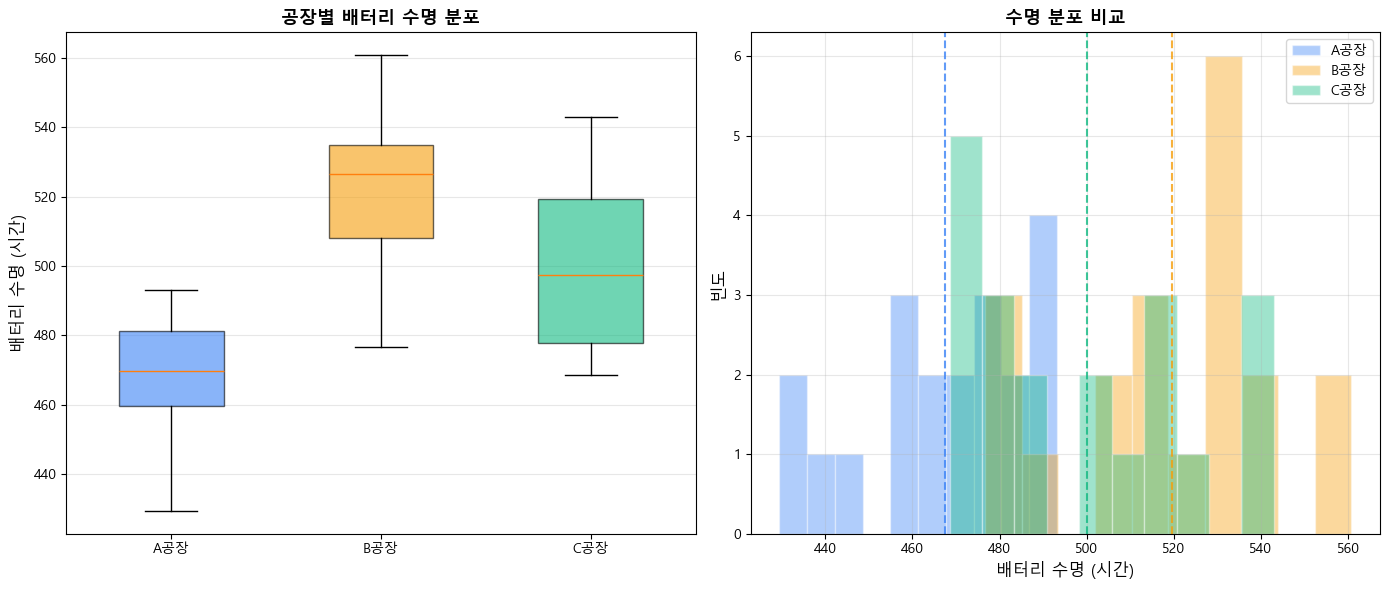

In [3]:
# 분포 시각화: 박스플롯 + 히스토그램
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

colors = ['#3B82F6', '#F59E0B', '#10B981']
bp = axes[0].boxplot([factory_a, factory_b, factory_c],
                      labels=['A공장', 'B공장', 'C공장'],
                      patch_artist=True, widths=0.5)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

axes[0].set_ylabel('배터리 수명 (시간)', fontsize=12)
axes[0].set_title('공장별 배터리 수명 분포', fontsize=13, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

for data, name, color in [(factory_a, 'A공장', '#3B82F6'),
                           (factory_b, 'B공장', '#F59E0B'),
                           (factory_c, 'C공장', '#10B981')]:
    axes[1].hist(data, bins=10, alpha=0.4, color=color, edgecolor='white', label=name)
    axes[1].axvline(data.mean(), color=color, linestyle='--', alpha=0.8)

axes[1].set_xlabel('배터리 수명 (시간)', fontsize=12)
axes[1].set_ylabel('빈도', fontsize=12)
axes[1].set_title('수명 분포 비교', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 문제 1-1: 가설 설정 및 가정 검정

**(a)** 분석 목표에 맞는 **귀무가설(H₀)** 과 **대립가설(H₁)** 을 수식으로 설정하세요.

**(b)** 각 공장 데이터의 **정규성 검정**(Shapiro-Wilk)을 수행하세요.

**(c)** 3개 공장의 **Q-Q Plot**을 나란히 그리세요.

**(d)** 정규성이 충족된다면, **등분산 검정**(Levene)을 수행하세요.

**(e)** 가정 검정 결과를 종합하여 **어떤 검정을 사용할지** 결정하세요.
의사결정 과정을 단계별로 설명하세요.

> **의사결정 흐름**: 정규성 확인 → (충족 시) 등분산 확인 → 검정 방법 선택

In [4]:
print("\n[문제 1-1] 가설 설정 및 가정 검정")
print("-" * 40)

# TODO (a): 가설 설정
print("세 공장의 평균 배터리 수명은 모두 같다")
print("적어도 하나의 공장 평균 수명은 다르다")
# TODO (b): 정규성 검정 (각 공장별)
# 1) Shapiro-Wilk test
for i in [factory_a,factory_b,factory_c]:
    stat, p = stats.shapiro(i)   # x: sample OR residuals OR paired differences
    print("Shapiro p} =", p)
print("전부 정규성 기각 못함.")


[문제 1-1] 가설 설정 및 가정 검정
----------------------------------------
세 공장의 평균 배터리 수명은 모두 같다
적어도 하나의 공장 평균 수명은 다르다
Shapiro p = 0.10363990852135674
Shapiro p = 0.1745861714279393
Shapiro p = 0.05400965107411224


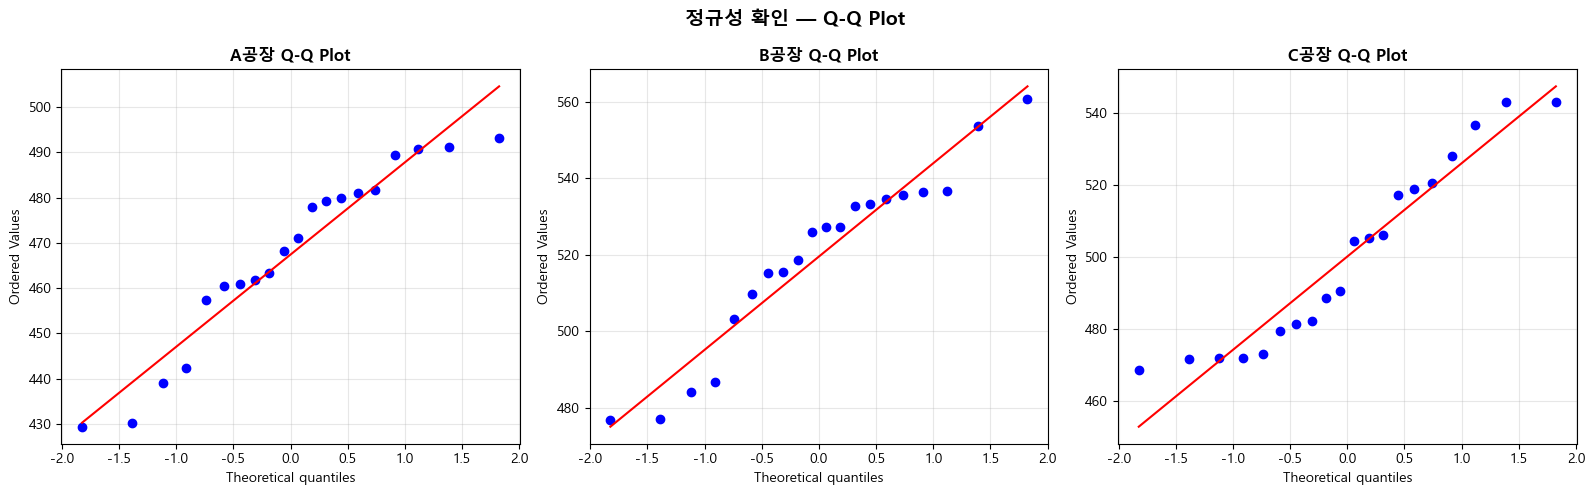

In [6]:
# TODO (c): Q-Q Plot (3개 공장)
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle("정규성 확인 — Q-Q Plot", fontsize=14, fontweight='bold')
stats.probplot(factory_a, dist="norm", plot=axes[0])
stats.probplot(factory_b, dist="norm", plot=axes[1])
stats.probplot(factory_c, dist="norm", plot=axes[2])
# TODO: 각 공장의 Q-Q Plot 그리기
for ax, data, name, color in [(axes[0], factory_a, 'A공장', '#3B82F6'),
                                (axes[1], factory_b, 'B공장', '#F59E0B'),
                                (axes[2], factory_c, 'C공장', '#10B981')]:
    ax.set_title(f"{name} Q-Q Plot", fontsize=12, fontweight="bold")
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [7]:
# TODO (d): 등분산 검정 (정규성 충족 시)
stat, p = stats.levene(factory_a,factory_b,factory_c)  # pass 3개 이상 집단 too
print("Levene p =", p)
# TODO (e): 검정 방법 결정
print("등분산성 가정을 기각하지 못한다.")
print(" anova_oneway 검정 사용")

Levene p = 0.35171154787380404


### 문제 1-2: ANOVA 검정 수행 및 효과크기

**(a)** 1-1에서 결정한 검정을 수행하세요 (α = 0.05).

**(b)** 전체 효과크기(η² 또는 η²_H)를 계산하고 해석하세요.

**(c)** ω²(오메가제곱)을 계산할 수 있다면 함께 보고하세요.

**(d)** 검정 결과(p-value)와 효과크기를 종합하여 결론을 내리세요.

In [ ]:
print("\n[문제 1-2] ANOVA 검정 수행 및 효과크기")
print("-" * 40)

# 표본 데이터 생성
groups = ['A공장'] * 20 + ['B공장'] * 20 + ['C공장'] * 20
lifetimes = np.concatenate([factory_a, factory_b, factory_c])
df_battery = pd.DataFrame({'공장': groups, '수명': lifetimes})

print("배터리 데이터 샘플:")
display(df_battery.sample(5))
print("기술통계:")
display(df_battery.describe().round(2))

In [8]:

# TODO (a): 검정 수행
alpha = 0.05
# g1, g2, g3 : group arrays (extend as needed)
f_stat, p_value = stats.f_oneway(factory_a, factory_b, factory_c)
print(f"[One-way ANOVA] F = {f_stat:.4g}, p = {p_value:.4g}, alpha = {alpha}")

if p_value < alpha:
    print("→ 결론: 귀무가설 기각 (집단 평균에 차이가 있을 가능성이 큼)")
    print("→ 다음 단계(권장):")
    print("   - 등분산이 대략 성립하면: Tukey HSD")
else:
    print("→ 결론: 귀무가설 기각 실패 (평균 차이에 대한 증거 부족)")

groups = [factory_a, factory_b, factory_c]  # TODO extend
all_y = np.concatenate(groups)
grand_mean = np.mean(all_y)

# sums of squares
ss_between = sum(len(g)*(np.mean(g)-grand_mean)**2 for g in groups)
ss_within = sum(np.sum((g - np.mean(g))**2) for g in groups)
ss_total = ss_between + ss_within

# effect sizes
eta2 = ss_between / ss_total if ss_total > 0 else np.nan
k = len(groups)
n = len(all_y)
df_between = k - 1
df_within = n - k
ms_within = ss_within / df_within
omega2 = (ss_between - df_between*ms_within) / (ss_total + ms_within) if (ss_total + ms_within) > 0 else np.nan
f = np.sqrt(eta2 / (1 - eta2)) if (eta2 is not np.nan and eta2 < 1) else np.nan

print(f"[효과크기] eta^2 = {eta2:.4f}, omega^2 = {omega2:.4f}, Cohen's f = {f:.4f}")
print("  (해석기준) eta^2: 0.01=작음, 0.06=중간, 0.14=큼 (분야에 따라 달라질 수 있음)")

# TODO (d): 종합 결론
print("집단 평균간에 차이가 있을 가능성이 크다는 것을 알았으며, 효과크기는 중간 정도 된다고 볼 수 있다.")

[One-way ANOVA] F = 25.62, p = 1.155e-08, alpha = 0.05
→ 결론: 귀무가설 기각 (집단 평균에 차이가 있을 가능성이 큼)
→ 다음 단계(권장):
   - 등분산이 대략 성립하면: Tukey HSD
   - 이분산이면: Welch ANOVA + Games–Howell
[효과크기] eta^2 = 0.4734, omega^2 = 0.4507, Cohen's f = 0.9481
  (해석기준) eta^2: 0.01=작음, 0.06=중간, 0.14=큼 (분야에 따라 달라질 수 있음)


### 문제 1-3: 사후검정 — 어떤 공장 쌍이 다른가?

ANOVA가 유의하다면, **"적어도 하나가 다르다"** 는 것만 알 수 있습니다.
**어떤 공장 쌍**이 다른지 확인하려면 사후검정이 필요합니다.

**(a)** 사용한 검정 방법에 맞는 사후검정을 수행하세요.

> | 검정 방법 | 사후검정 |
> |-----------|---------|
> | One-way ANOVA | Tukey HSD |
> | Welch's ANOVA | Games-Howell |
> | Kruskal-Wallis | Dunn 검정 (Bonferroni 보정) |

**(b)** 쌍별 효과크기를 계산하세요.

> - Tukey HSD 후 → Cohen's d (`pg.compute_effsize(x, y, eftype='cohen')`)
> - Games-Howell 후 → Hedges' g (`pg.compute_effsize(x, y, eftype='hedges')`)
> - Dunn 검정 후 → 중앙값 차이로 방향과 크기 해석

**(c)** 사후검정 결과를 종합하여, 구체적으로 어떤 공장이 어떻게 다른지 해석하세요.

**(d)** 공장별 평균 배터리 수명을 막대 그래프(±SEM 오차막대 포함)로 시각화하세요.

In [12]:
print("\n[문제 1-3] 사후검정")
print("-" * 40)

alpha = 0.05  # TODO

# TODO INPUT:
# - g1, g2, g3: 1D numeric arrays (extend for more groups)
# - 라벨 'g1','g2','g3'는 원하면 실제 집단명으로 바꾸세요.

# 1) long-format data
df = pd.DataFrame({
    "y": np.concatenate([factory_a, factory_b, factory_c]),   # TODO extend
    "group": (["g1"]*len(factory_a) + ["g2"]*len(factory_b) + ["g3"]*len(factory_c))
})

# 2) Tukey HSD
res = pairwise_tukeyhsd(endog=df["y"], groups=df["group"], alpha=alpha)

# 3) 결과를 DataFrame으로 변환
tbl = pd.DataFrame(res.summary().data[1:], columns=res.summary().data[0])
# columns: group1 group2 meandiff p-adj lower upper reject

# ---- 효과크기 헬퍼 ----
def _pooled_sd(a, b):
    a = np.asarray(a, dtype=float); b = np.asarray(b, dtype=float)
    n1, n2 = len(a), len(b)
    s1, s2 = np.var(a, ddof=1), np.var(b, ddof=1)
    return np.sqrt(((n1-1)*s1 + (n2-1)*s2) / (n1 + n2 - 2))

def cohens_d(a, b):
    sp = _pooled_sd(a, b)
    return (np.mean(a) - np.mean(b)) / sp if sp > 0 else np.nan

def hedges_g(a, b):
    # 소표본에서 왜 Hedges' g를 쓰나요?
    # - Cohen's d는 표본수가 작을 때 효과크기를 약간 과대추정하는 경향이 있습니다.
    # - Hedges' g는 보정계수(J)를 곱해 이 편향을 줄여, 소표본에서 더 정확한 추정을 제공합니다.
    a = np.asarray(a, dtype=float); b = np.asarray(b, dtype=float)
    n1, n2 = len(a), len(b)
    d = cohens_d(a, b)
    J = 1 - 3 / (4*(n1+n2) - 9)
    return J * d

def auto_effect(a, b, small_n=20):
    # 자동 선택: 두 집단 중 하나라도 n < small_n 이면 Hedges' g 사용(기본 20)
    if len(a) < small_n or len(b) < small_n:
        return hedges_g(a, b), "Hedges' g (소표본 보정)"
    return cohens_d(a, b), "Cohen's d"

def ci_comment(lower, upper):
    lower = float(lower); upper = float(upper)
    if lower > 0 or upper < 0:
        return "신뢰구간에 0이 없음 → 통계적으로 신뢰 가능한 차이"
    return "신뢰구간에 0이 포함 → 차이가 통계적으로 불확실할 수 있음"

group_map = {"g1": factory_a, "g2": factory_b, "g3": factory_c}  # TODO extend

effects = []
effect_types = []
comments = []

for _, r in tbl.iterrows():
    a = group_map[r["group1"]]
    b = group_map[r["group2"]]
    es, es_type = auto_effect(a, b)
    effects.append(es)
    effect_types.append(es_type)
    comments.append(ci_comment(r["lower"], r["upper"]))

tbl["effect_size"] = effects
tbl["effect_type"] = effect_types
tbl["CI_comment"] = comments

print("[Tukey HSD] 전체 결과 + 효과크기 (전체 쌍)")
print(tbl.to_string(index=False))

print()
print("결국 g1, g2, g3 서로 유의미한 차이가 존재한다는 것을 볼 수 있으며, 효과크기는 비교적 작은 정도로 나온다고 볼 수 있다")


[문제 1-3] 사후검정
----------------------------------------
[Tukey HSD] 전체 결과 + 효과크기 (전체 쌍)
group1 group2  meandiff  p-adj    lower   upper  reject  effect_size effect_type                    CI_comment
    g1     g2    52.085 0.0000  34.3875 69.7825    True    -2.367067   Cohen's d 신뢰구간에 0이 없음 → 통계적으로 신뢰 가능한 차이
    g1     g3    32.660 0.0001  14.9625 50.3575    True    -1.423130   Cohen's d 신뢰구간에 0이 없음 → 통계적으로 신뢰 가능한 차이
    g2     g3   -19.425 0.0283 -37.1225 -1.7275    True     0.785394   Cohen's d 신뢰구간에 0이 없음 → 통계적으로 신뢰 가능한 차이

결국 g1, g2, g3 서로 유의미한 차이가 존재한다는 것을 볼 수 있으며, 효과크기는 비교적 작은 정도로 나온다고 볼 수 있다


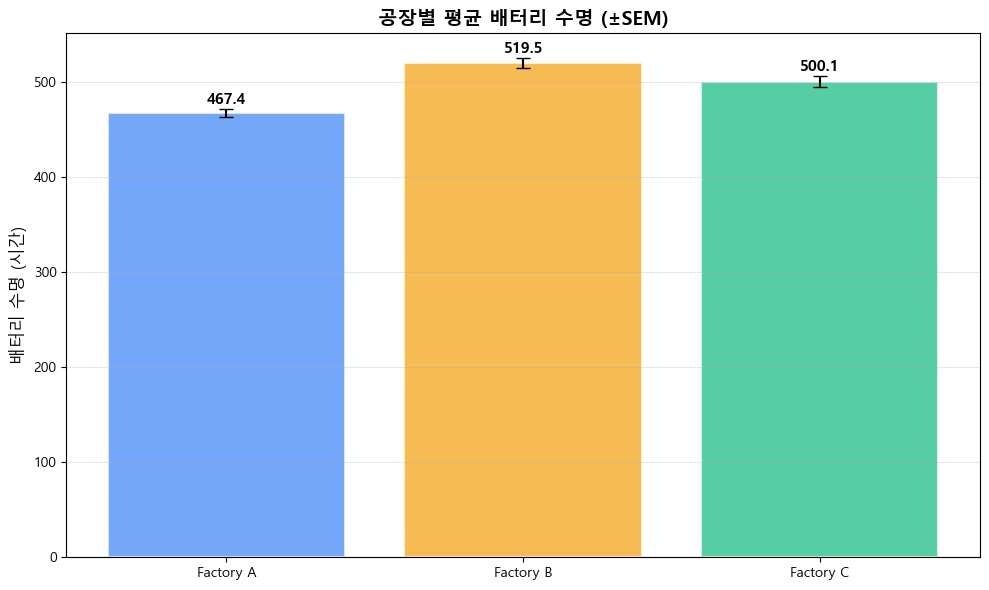

In [14]:
# TODO (d): 막대 그래프 (±SEM)
fig, ax = plt.subplots(figsize=(10, 6))

groups = {
    "Factory A": factory_a,
    "Factory B": factory_b,
    "Factory C": factory_c
}

means = [np.mean(v) for v in groups.values()]
sems  = [np.std(v, ddof=1) / np.sqrt(len(v)) for v in groups.values()]

# TODO: 막대 그래프 + 오차막대 + 평균값 텍스트 표시
bars = ax.bar(list(groups.keys()), means, yerr=sems, capsize=5,
               color=colors, alpha=0.7, edgecolor='white', linewidth=1.5)
for bar, mean, sem in zip(bars, means, sems):
    ax.text(bar.get_x() + bar.get_width()/2., mean + sem + 1,
            f'{mean:.1f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_ylabel('배터리 수명 (시간)', fontsize=12)
ax.set_title('공장별 평균 배터리 수명 (±SEM)', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

---

## 문제 2: 직원 데이터 상관분석

한 IT 기업에서 직원 30명의 데이터를 수집했습니다.
경력(년), 월급여(만원), 프로젝트 완료 수, 직무 만족도(1~10점)의 관계를 분석합니다.

**분석 목표**:
- 변수 간 상관관계를 파악하고, 어떤 변수 쌍이 유의한 상관을 보이는지 확인합니다.
- Pearson과 Spearman 상관계수를 비교하여 데이터의 특성을 파악합니다.

**주어진 데이터:**

In [15]:
print("\n[문제 2] 직원 데이터 상관분석")
print("=" * 50)

np.random.seed(552)
n_emp = 30

experience = np.round(np.random.uniform(1, 15, n_emp), 1)
salary = np.round(2500 + 180 * experience + np.random.normal(0, 400, n_emp), 0)
projects = np.round(np.clip(2 + 0.8 * experience + np.random.normal(0, 3, n_emp), 0, 30), 0).astype(int)
satisfaction = np.round(np.clip(4 + 0.3 * experience - 0.0005 * salary + np.random.normal(0, 1.8, n_emp), 1, 10), 1)

df_emp = pd.DataFrame({
    '경력(년)': experience,
    '월급여(만원)': salary,
    '프로젝트수': projects,
    '만족도': satisfaction
})
print("직원 데이터 샘플:")
display(df_emp.sample(5))
print("기술통계:")
display(df_emp.describe().round(2))


[문제 2] 직원 데이터 상관분석
직원 데이터 샘플:


,경력(년),월급여(만원),프로젝트수,만족도
23,8.7,4354.0,15,6.3
3,12.2,4357.0,11,6.9
15,8.8,4159.0,11,5.3
24,5.8,2343.0,5,8.6
4,3.8,3216.0,3,4.1


기술통계:


,경력(년),월급여(만원),프로젝트수,만족도
count,30.00,30.00,30.00,30.00
mean,8.69,3973.30,9.03,4.49
std,4.07,871.03,4.86,2.04
min,1.80,2094.00,0.00,1.00
25%,5.72,3248.00,6.00,3.02
50%,8.75,4045.00,8.50,4.05
75%,12.15,4703.50,13.75,6.20
max,14.60,5378.00,19.00,8.60


### 문제 2-1: 산점도와 상관 행렬

**(a)** `경력(년)`과 `월급여(만원)`의 산점도를 그리고, 회귀선을 추가하세요.
시각적으로 어떤 관계가 보이는지 서술하세요.

**(b)** 전체 변수의 **Pearson 상관 행렬**을 계산하고 히트맵으로 시각화하세요.

> `df_emp.corr(method='pearson')` + `seaborn.heatmap()`

**(c)** 전체 변수의 **Spearman 상관 행렬**도 함께 히트맵으로 그려서 나란히 비교하세요.


[문제 2-1] 산점도와 상관 행렬
----------------------------------------


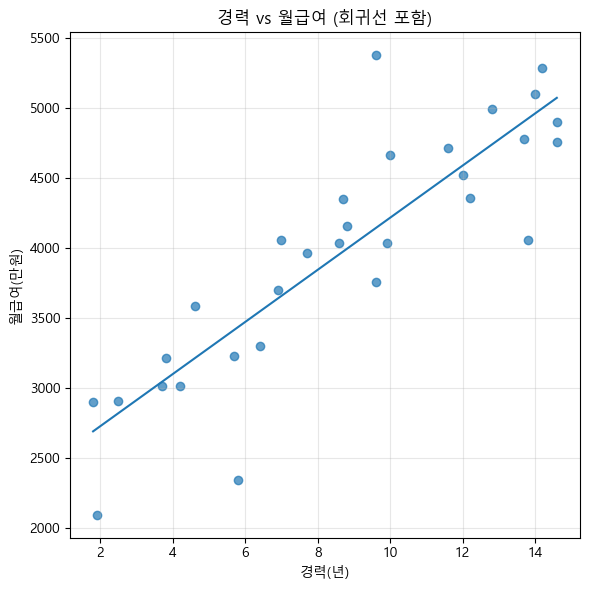

(a) 시각적 관찰 결과 해석:


In [ ]:
print("\n[문제 2-1] 산점도와 상관 행렬")
print("-" * 40)
fig, axes = plt.subplots(figsize=(6, 6))
# TODO (a): 경력 vs 월급여 산점도 + 회귀선
x = df_emp['경력(년)'].values
y = df_emp['월급여(만원)'].values
axes.scatter(x, y, alpha=0.7)
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
x_line = np.linspace(x.min(), x.max(), 100)
y_line = intercept + slope * x_line
axes.plot(x_line, y_line)

axes.set_title("경력 vs 월급여 (회귀선 포함)")
axes.set_xlabel("경력(년)")
axes.set_ylabel("월급여(만원)")
axes.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("(a) 시각적 관찰 결과 해석:")
# print(f"    이상치가 조금 존재하는 형태를 보인다.")

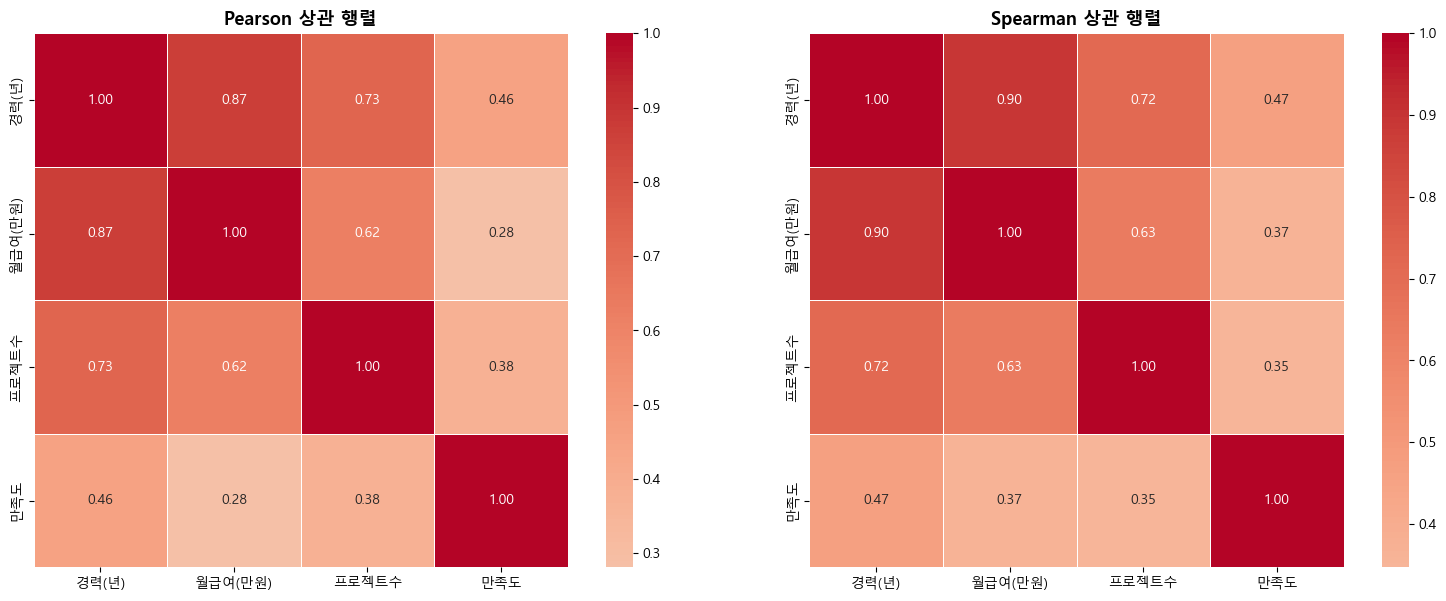

In [26]:
import seaborn as sns

# Pearson 상관행렬
corr_matrix = df_emp.corr(method='pearson')

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Pearson
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    center=0,
    square=True,
    linewidths=0.5,
    ax=axes[0]
)
axes[0].set_title('Pearson 상관 행렬', fontsize=13, fontweight='bold')

# Spearman
sns.heatmap(
    df_emp.corr(method='spearman'),
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    center=0,
    square=True,
    linewidths=0.5,
    ax=axes[1]
)
axes[1].set_title('Spearman 상관 행렬', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

### 문제 2-2: 상관계수 가설검정

**(a)** `경력(년)`과 `월급여(만원)` 사이의 **Pearson 상관계수**와 **p-value**를 구하세요.

**(b)** 같은 변수 쌍에 대해 **Spearman 상관계수**와 **p-value**를 구하세요.

**(c)** 두 상관계수를 비교하세요. 차이가 크다면/작다면 어떤 의미인지 설명하세요.

In [30]:
print("\n[문제 2-2] 상관계수 가설검정")
print("-" * 40)
alpha = 0.05 
# TODO (a): Pearson 상관계수
# x, y: 1D 배열(길이 동일)
r, p_value = stats.pearsonr(x, y)

print("[피어슨 상관(Pearson correlation)]")
print(f"  r = {r:.4f}, p = {p_value:.4g}, alpha = {alpha}")
if p_value < alpha:
    print("  → H0 기각: 선형 연관성에 대한 증거가 있습니다.")
else:
    print("  → H0 기각 실패: 선형 연관성의 증거가 부족합니다.")

# TODO (b): Spearman 상관계수
rho, p_spearman = stats.spearmanr(x, y)

print("\n[스피어만 상관(Spearman correlation)]")
print(f"  ρ = {rho:.4f}, p = {p_spearman:.4g}, alpha = {alpha}")
if p_spearman < alpha:
    print("  → H0 기각: 단조(monotonic) 연관성에 대한 증거가 있습니다.")
else:
    print("  → H0 기각 실패: 단조 연관성의 증거가 부족합니다.")

# TODO (c): 비교
print(f"\n(c) Pearson vs Spearman 비교:")
diff = abs(r - rho)

if diff < 0.1:
    print("    차이: 두 상관계수가 거의 유사합니다.")
    print("    해석: 관계가 선형에 가깝고 이상치 영향이 크지 않은 것으로 보입니다.")
else:
    print("    차이: 두 상관계수에 차이가 존재합니다.")
    print("    해석: 비선형 관계이거나 이상치의 영향이 있을 가능성이 있습니다.")


[문제 2-2] 상관계수 가설검정
----------------------------------------
[피어슨 상관(Pearson correlation)]
  r = 0.8701, p = 4.22e-10, alpha = 0.05
  → H0 기각: 선형 연관성에 대한 증거가 있습니다.

[스피어만 상관(Spearman correlation)]
  ρ = 0.8965, p = 2.077e-11, alpha = 0.05
  → H0 기각: 단조(monotonic) 연관성에 대한 증거가 있습니다.

(c) Pearson vs Spearman 비교:
    차이: 두 상관계수가 거의 유사합니다.
    해석: 관계가 선형에 가깝고 이상치 영향이 크지 않은 것으로 보입니다.


### 문제 2-3: 다변량 상관분석과 해석

**(a)** `pg.pairwise_corr(df_emp, method='pearson')`으로 모든 변수 쌍의 상관분석을 수행하세요.
유의한 상관(p < 0.05)을 보이는 쌍을 모두 찾으세요.

**(b)** 유의한 상관을 보이는 변수 쌍 중에서, **상관이 인과를 의미하지 않는** 예시를 하나 들고,
왜 인과라고 할 수 없는지 교란변수의 가능성을 포함하여 설명하세요.

> **상관 vs 인과**: 두 변수가 함께 움직여도(상관), 한 변수가 다른 변수를 변화시킨다(인과)고
> 단정할 수 없습니다. 인과를 확인하려면 **실험(RCT, A/B 테스트)** 이 필요합니다.

**(c)** 만약 `경력`과 `만족도` 사이에 유의한 상관이 있다면,
"경력이 많을수록 만족도가 높다"고 결론 내릴 수 있나요?
왜 그런지/아닌지 교란변수(예: 직급, 급여, 업무 환경)의 관점에서 논의하세요.

In [34]:
print("\n[문제 2-3] 다변량 상관분석과 해석")
print("-" * 40)

# TODO (a): pairwise_corr
cols = ['경력(년)', '월급여(만원)', '프로젝트수', '만족도']

pair_rows = []
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        c1, c2 = cols[i], cols[j]
        x = df_emp[c1].values
        y = df_emp[c2].values

        r_p, p_p = stats.pearsonr(x, y)
        r_s, p_s = stats.spearmanr(x, y)

        pair_rows.append({
            "변수1": c1,
            "변수2": c2,
            "Pearson r": r_p,
            "Pearson p": p_p,
            "Spearman ρ": r_s,
            "Spearman p": p_s,
            "유의(Pearson)": (p_p < 0.05),
            "유의(Spearman)": (p_s < 0.05)
        })

pairwise_corr = pd.DataFrame(pair_rows)
print("(a) 변수쌍별 상관(피어슨/스피어만) 요약:")
display(pairwise_corr.round(4))


# TODO (b): 상관 vs 인과 — 교란변수 논의
print("상관은 '함께 변한다'는 뜻이지, 한 변수가 원인이 되는 것이 아니다.")

# TODO (c): 경력 vs 만족도 해석
x = df_emp['경력(년)'].values
y = df_emp['만족도'].values
r_p, p_p = stats.pearsonr(x, y)
r_s, p_s = stats.spearmanr(x, y)
if p_p < 0.05:
    direction = "양(+)의" if r_p > 0 else "음(-)의"
    print(f"해석: 경력과 만족도 사이에 통계적으로 유의한 {direction} 선형 상관이 관찰된다.")
else:
    print("해석: 경력과 만족도 사이에 유의한 선형 상관이 있다고 보기 어렵다.")

if abs(r_p - r_s) >= 0.1:
    print("Pearson과 Spearman 차이가 비교적 커 비선형/이상치 영향 가능성이 있어 Spearman도 함께 참고하는 것이 좋다.")
else:
    print("Pearson과 Spearman이 유사하여 관계가 대체로 단조이며, 이상치 영향이 크지 않은 편으로 보인다.")


[문제 2-3] 다변량 상관분석과 해석
----------------------------------------
(a) 변수쌍별 상관(피어슨/스피어만) 요약:


,변수1,변수2,Pearson r,Pearson p,Spearman ρ,Spearman p,유의(Pearson),유의(Spearman)
0,경력(년),월급여(만원),0.8701,0.0000,0.8965,0.0000,True,True
1,경력(년),프로젝트수,0.7319,0.0000,0.7182,0.0000,True,True
2,경력(년),만족도,0.4568,0.0112,0.4656,0.0095,True,True
3,월급여(만원),프로젝트수,0.6208,0.0003,0.6346,0.0002,True,True
4,월급여(만원),만족도,0.2812,0.1323,0.3663,0.0465,False,True
5,프로젝트수,만족도,0.3762,0.0405,0.3472,0.0601,True,False


상관은 '함께 변한다'는 뜻이지, 한 변수가 원인이 되는 것이 아니다.
해석: 경력과 만족도 사이에 통계적으로 유의한 양(+)의 선형 상관이 관찰된다.
Pearson과 Spearman이 유사하여 관계가 대체로 단조이며, 이상치 영향이 크지 않은 편으로 보인다.


---

## 문제 3: 앱 UI 변경 A/B 테스트 (전환율 비교)

모바일 쇼핑 앱에서 결제 화면 UI를 개선하면 **구매 전환율**이 높아지는지 A/B 테스트를 수행합니다.

- **대조군(A)**: 기존 결제 화면
- **실험군(B)**: 개선된 결제 화면 (버튼 크기 확대 + 단계 축소)
- **지표**: 구매 전환율 (결제 완료 비율)
- **현재 전환율**: 8%
- **비즈니스 목표**: 최소 2%p 이상 개선을 탐지하고 싶음 (8% → 10%)

**분석 목표**: 개선된 UI가 기존 대비 전환율을 유의하게 높이는지 검정합니다.

---

### 문제 3-1: 실험 설계 — 표본 크기 산정

A/B 테스트를 실행하기 **전에** 필요한 표본 크기를 산정합니다.

**(a)** 실험 설계 파라미터를 정리하세요.

**(b)** **효과크기(Cohen's h)** 를 계산하세요.

**(c)** **집단당 필요 표본 크기**를 산정하세요.

**(d)** 양측검정과 단측검정 각각에 대해 표본 크기를 구하고, 차이를 비교하세요.
이 실험에서는 어떤 검정이 더 적절한지 근거와 함께 설명하세요.

In [39]:
print("\n[문제 3] 앱 UI 변경 A/B 테스트")
print("=" * 50)
print("\n[문제 3-1] 실험 설계 — 표본 크기 산정")
print("-" * 40)
## 모바일 쇼핑 앱에서 결제 화면 UI를 개선하면 **구매 전환율**이 높아지는지 A/B 테스트를 수행합니다.
baseline_rate = 0.08   # 기존 전환율
mde = 0.02             # 최소 탐지 효과 (2%p)
alpha = 0.05           # 유의수준
power_target = 0.80    # 검정력

# TODO (a): 파라미터 정리
p1 = baseline_rate
p2 = baseline_rate + mde

# TODO (b): 효과크기 (Cohen's h)
effect_size = proportion_effectsize(p2, p1)

# TODO (c): 필요 표본 크기
n_per_group = NormalIndPower().solve_power(
    effect_size=effect_size,
    power=power_target,
    alpha=alpha,
    ratio=1.0,          # A/B 동일 크기
    alternative='larger'
)
print(int(np.ceil(n_per_group)))

# TODO (d): 양측 vs 단측 비교 및 선택

n_two = NormalIndPower().solve_power(effect_size=effect_size,
                             power=power_target,
                             alpha=alpha,
                             ratio=1.0,
                             alternative='two-sided')

n_one = NormalIndPower().solve_power(effect_size=effect_size,
                             power=power_target,
                             alpha=alpha,
                             ratio=1.0,
                             alternative='larger')

print(f"    양측 검정 필요 표본 ≈ {np.ceil(n_two):.0f}명 (그룹당)")
print(f"    단측 검정 필요 표본 ≈ {np.ceil(n_one):.0f}명 (그룹당)")

print("    해석: 단측 검정은 필요한 표본 수가 더 적다, '증가 여부'만 관심이 있으면 단측 검정을 선택한다.")


[문제 3] 앱 UI 변경 A/B 테스트

[문제 3-1] 실험 설계 — 표본 크기 산정
----------------------------------------
2525
    양측 검정 필요 표본 ≈ 3205명 (그룹당)
    단측 검정 필요 표본 ≈ 2525명 (그룹당)
    해석: 단측 검정은 필요한 표본 수가 더 적다, '증가 여부'만 관심이 있으면 단측 검정을 선택한다.


### 문제 3-2: A/B 테스트 실행 및 검정

실험을 진행하여 아래 데이터를 수집했습니다.

**(a)** 각 집단의 전환율을 계산하세요.

**(b)** **z-비율검정**을 수행하세요.

> `proportions_ztest(count, nobs, alternative=...)`

**(c)** **효과크기(Cohen's h)** 를 관측된 전환율로 계산하세요.

**(d)** 각 집단의 **95% 신뢰구간**을 구하세요.

> `proportion_confint(count, nobs, alpha=0.05, method='wilson')`

**(e)** **비율 차이의 95% 신뢰구간**을 구하세요.

> `confint_proportions_2indep(count1, nobs1, count2, nobs2, method='wald')`

**(f)** **상대적 개선율(Relative Lift)** 을 계산하세요.

> 상대적 개선율 = (실험군 전환율 − 대조군 전환율) / 대조군 전환율 × 100

**(g)** 전환율 비교 막대 그래프를 그리세요 (95% 신뢰구간 포함).

In [48]:
print("\n[문제 3-2] A/B 테스트 실행 및 검정")
print("-" * 40)

np.random.seed(553)
n_per_group = 2600  # 실험에 참여한 인원 (집단당)

# 데이터 생성 (시뮬레이션)
control_conv = np.random.binomial(1, 0.08, n_per_group)    # 대조군: 8%
treatment_conv = np.random.binomial(1, 0.105, n_per_group)  # 실험군: 10.5%

# TODO (a): 전환율 계산
x_c = int(control_conv.sum())
x_t = int(treatment_conv.sum())
n_c = int(len(control_conv))
n_t = int(len(treatment_conv))
p_c = x_c / n_c
p_t = x_t / n_t
print("(a) 전환율")
print(f"    Control  : {p_c:.4f}")
print(f"    Treatment: {p_t:.4f}")

# TODO (b): z-비율검정
count = np.array([x_t, x_c])
nobs  = np.array([n_t, n_c])
z_stat, p_value = proportions_ztest(count=count, nobs=nobs, alternative= "larger")
print(f"z = {z_stat:.4f}, p-value = {p_value:.4f}")

# TODO (c): 관측된 효과크기 (Cohen's h)
h = proportion_effectsize(p_t, p_c)
print(f"Cohen's h = {h:.4f}")

# TODO (d): 실험군, 대조군 95% 신뢰구간
ci_c = proportion_confint(count=x_c, nobs=n_c, alpha=alpha, method='wilson')
ci_t = proportion_confint(count=x_t, nobs=n_t, alpha=alpha, method='wilson')
print(f"Control  : [{ci_c[0]:.4f}, {ci_c[1]:.4f}]")
print(f"Treatment: [{ci_t[0]:.4f}, {ci_t[1]:.4f}]")

# TODO (e): 비율 차이의 95% 신뢰구간
ci_diff = confint_proportions_2indep(
    count1=x_t, nobs1=n_t,
    count2=x_c, nobs2=n_c,
    method='wald'
)
diff = p_t - p_c
print(f"diff = {diff:.4f}")
print(f"CI = [{ci_diff[0]:.4f}, {ci_diff[1]:.4f}]")

# TODO (f): 상대적 개선율
change = (diff / p_c) * 100 if p_c > 0 else np.nan
print(f"개선율 = {change:.2f}%")


[문제 3-2] A/B 테스트 실행 및 검정
----------------------------------------
(a) 전환율
    Control  : 0.0831
    Treatment: 0.1112
z = 3.4187, p-value = 0.0003
Cohen's h = 0.0951
Control  : [0.0731, 0.0943]
Treatment: [0.0996, 0.1238]
diff = 0.0281
CI = [0.0120, 0.0442]
개선율 = 33.80%


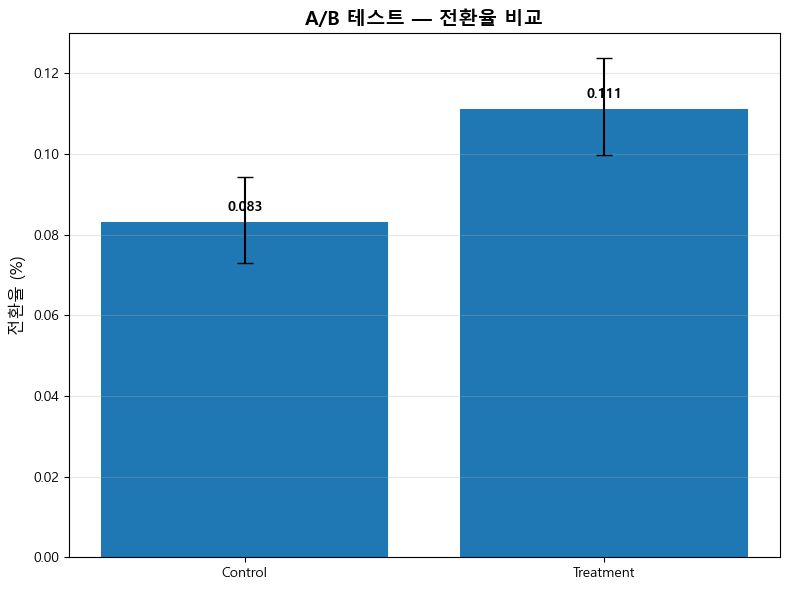

In [49]:
# TODO (g): 전환율 비교 막대 그래프 (신뢰구간 포함)
fig, ax = plt.subplots(figsize=(8, 6))

# TODO: 막대 그래프 그리기
labels = ["Control", "Treatment"]
rates = [p_c, p_t]
bar_colors = ['#3B82F6', '#F59E0B']
bars = ax.bar(labels, rates, color=bar_colors, alpha=0.8, edgecolor='white')
err_low  = [p_c - ci_c[0], p_t - ci_t[0]]
err_high = [ci_c[1] - p_c, ci_t[1] - p_t]
yerr = np.array([err_low, err_high])
bars = ax.bar(labels, rates, yerr=yerr, capsize=6)
for bar, rate in zip(bars, rates):
    ax.text(bar.get_x() + bar.get_width()/2, rate + 0.002, f"{rate:.3f}",
            ha="center", va="bottom", fontweight="bold")

ax.set_ylabel('전환율 (%)', fontsize=12)
ax.set_title('A/B 테스트 — 전환율 비교', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### 문제 3-3: 비즈니스 의사결정

**(a)** A/B 테스트 결과를 종합하여, UI 변경을 **전체 사용자에게 적용할지** 의사결정을 내리세요.
아래 항목을 모두 포함하여 보고서 형식으로 작성하세요.

> | 항목 | 내용 |
> |------|------|
> | 통계적 유의성 | p-value와 유의수준 비교 |
> | 효과크기 | Cohen's h와 해석 |
> | 실무적 의미 | 상대적 개선율과 비즈니스 임팩트 |
> | 신뢰구간 | 비율 차이의 신뢰구간과 두 집단의 신뢰구간 겹침 여부 |
> | 최종 권고 | 적용 / 미적용 / 추가 실험 필요 |

**(b)** 만약 p-value는 유의하지만 효과크기가 매우 작다면(예: Cohen's h < 0.1),
어떤 의사결정이 적절한지 설명하세요.

In [57]:
print("\n[문제 3-3] 비즈니스 의사결정")
print("-" * 40)

# TODO (a): 종합 보고서
print("(a) A/B 테스트 결과 보고서:")
# print(f"    [통계적 유의성] ...")
if p_value < alpha:
    sig_msg = "유의수준 0.05에서 통계적으로 유의함 (귀무가설 기각)"
else:
    sig_msg = "유의수준 0.05에서 통계적으로 유의하지 않음 (귀무가설 기각 실패)"

# print(f"    [효과크기] ...")
if abs(h) < 0.1:
    effect_msg = "매우 작은 효과"
elif abs(h) < 0.3:
    effect_msg = "작은 효과"
elif abs(h) < 0.5:
    effect_msg = "중간 효과"
else:
    effect_msg = "큰 효과"

# print(f"    [실무적 의미] ...")
print(f"대조군 전환율 {p_c:.3%}, 실험군 {p_t:.3%}")
print(f"상대적 개선율 = {change:.2f}%")

# print(f"    [신뢰구간] ...")
print(f"Control 95% CI = [{ci_c[0]:.4f}, {ci_c[1]:.4f}]")
print(f"Treatment 95% CI = [{ci_t[0]:.4f}, {ci_t[1]:.4f}]")
print(f"차이(T-C) 95% CI = [{ci_diff[0]:.4f}, {ci_diff[1]:.4f}]")
print("차이의 신뢰구간이 0을 포함하지 않음 → 개선 효과가 비교적 확실")

# print(f"    [최종 권고] ...")
if (p_value < alpha) and (ci_diff[0] > 0):
    decision = "UI 변경을 전체 사용자에게 적용 권고"
elif p_value < alpha:
    decision = "통계적으로 유의하지만 불확실성이 있어 추가 실험 권고"
else:
    decision = "유의한 개선 증거 부족 → 현 단계에서는 미적용 권고"
print(decision)

# TODO (b): 유의하지만 효과 작은 경우
print(f"\n(b) p 유의 + 효과크기 작은 경우의 의사결정:")
print(f"표본이 크면 매우 작은 차이도 통계적으로 유의해질 수 있기에, 추가 실험을 해보는 등 다른 방법을 고려할 필요가 있다.")



[문제 3-3] 비즈니스 의사결정
----------------------------------------
(a) A/B 테스트 결과 보고서:
대조군 전환율 8.308%, 실험군 11.115%
상대적 개선율 = 33.80%
Control 95% CI = [0.0731, 0.0943]
Treatment 95% CI = [0.0996, 0.1238]
차이(T-C) 95% CI = [0.0120, 0.0442]
차이의 신뢰구간이 0을 포함하지 않음 → 개선 효과가 비교적 확실
UI 변경을 전체 사용자에게 적용 권고

(b) p 유의 + 효과크기 작은 경우의 의사결정:
표본이 크면 매우 작은 차이도 통계적으로 유의해질 수 있기에, 추가 실험을 해보는 등 다른 방법을 고려할 필요가 있다.


---

## 문제 4: 학습 앱 A/B 테스트 (연속형 지표 — 학습 시간 비교)

온라인 학습 앱에서 새로운 **게이미피케이션 기능**(배지, 레벨업 시스템)을 도입하면
일일 학습 시간이 늘어나는지 A/B 테스트를 진행합니다.

- **대조군(A)**: 기존 앱 (게이미피케이션 없음)
- **실험군(B)**: 게이미피케이션 도입 버전
- **지표**: 일일 학습 시간 (분)

**분석 목표**: 게이미피케이션 도입이 일일 학습 시간을 유의하게 증가시키는지 검정합니다.

**주어진 데이터:**

In [58]:
print("\n[문제 4] 학습 앱 A/B 테스트 — 학습 시간 비교")
print("=" * 50)

np.random.seed(554)
n_ab = 300

# 학습 시간 데이터 (지수분포 — 우측 꼬리가 긴 비대칭 분포)
time_control = np.round(np.random.exponential(scale=25, size=n_ab), 1)    # 대조군: 평균 25분
time_treatment = np.round(np.random.exponential(scale=30, size=n_ab), 1)  # 실험군: 평균 30분

print(f"  대조군 (n={n_ab}): 평균={time_control.mean():.1f}분, 중앙값={np.median(time_control):.1f}분, SD={time_control.std(ddof=1):.1f}분")
print(f"  실험군 (n={n_ab}): 평균={time_treatment.mean():.1f}분, 중앙값={np.median(time_treatment):.1f}분, SD={time_treatment.std(ddof=1):.1f}분")


[문제 4] 학습 앱 A/B 테스트 — 학습 시간 비교
  대조군 (n=300): 평균=25.8분, 중앙값=18.6분, SD=25.2분
  실험군 (n=300): 평균=27.7분, 중앙값=22.6분, SD=24.1분


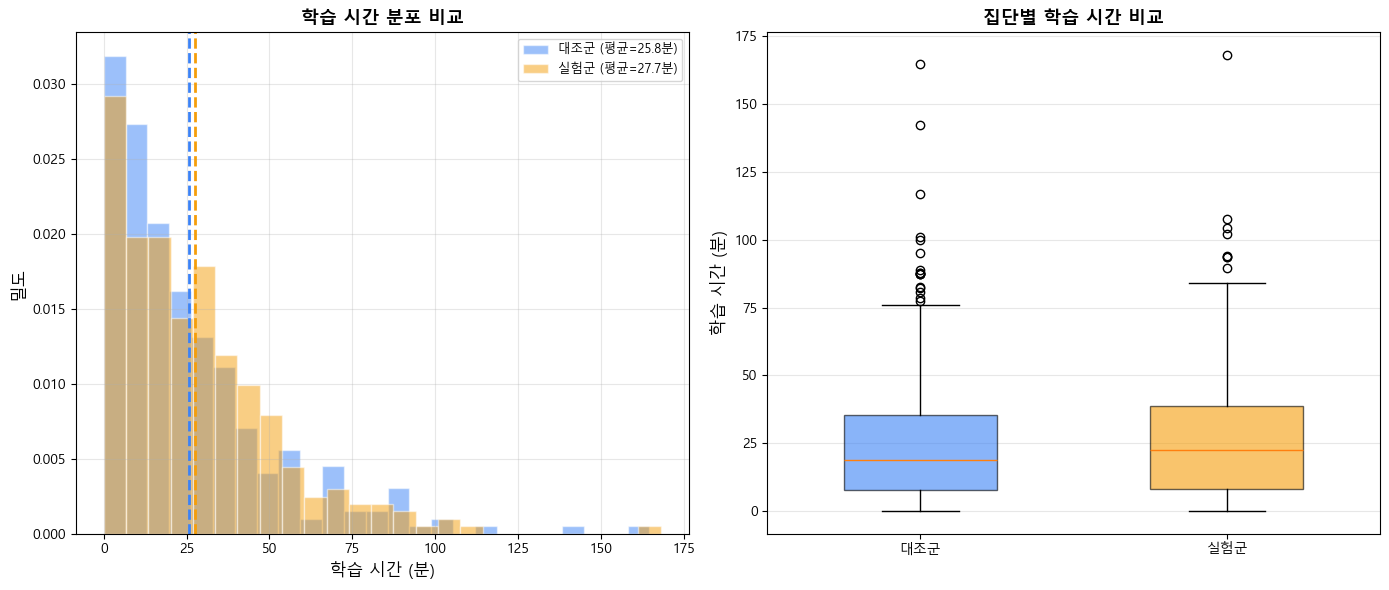

In [59]:
# 분포 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].hist(time_control, bins=25, alpha=0.5, color='#3B82F6', edgecolor='white',
             label=f'대조군 (평균={time_control.mean():.1f}분)', density=True)
axes[0].hist(time_treatment, bins=25, alpha=0.5, color='#F59E0B', edgecolor='white',
             label=f'실험군 (평균={time_treatment.mean():.1f}분)', density=True)
axes[0].axvline(time_control.mean(), color='#3B82F6', linestyle='--', linewidth=2)
axes[0].axvline(time_treatment.mean(), color='#F59E0B', linestyle='--', linewidth=2)
axes[0].set_xlabel('학습 시간 (분)', fontsize=12)
axes[0].set_ylabel('밀도', fontsize=12)
axes[0].set_title('학습 시간 분포 비교', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=9)
axes[0].grid(alpha=0.3)

bp = axes[1].boxplot([time_control, time_treatment],
                      labels=['대조군', '실험군'],
                      patch_artist=True, widths=0.5)
bp['boxes'][0].set_facecolor('#3B82F6')
bp['boxes'][0].set_alpha(0.6)
bp['boxes'][1].set_facecolor('#F59E0B')
bp['boxes'][1].set_alpha(0.6)
axes[1].set_ylabel('학습 시간 (분)', fontsize=12)
axes[1].set_title('집단별 학습 시간 비교', fontsize=13, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### 문제 4-1: 정규성 확인과 검정 방법 결정

**(a)** 각 집단의 **정규성 검정**(Shapiro-Wilk)을 수행하세요.

**(b)** 분포의 **왜도(skewness)** 를 계산하세요.

> `from scipy.stats import skew` → `skew(data)`

**(c)** 이 데이터에 t-검정을 적용할 수 있는지 판단하세요.
**중심극한정리(CLT)** 의 관점에서, 표본 크기(n=300)와 왜도를 함께 고려하여 설명하세요.

> | \|skew\| | 분류 | CLT 실무 기준 |
> |:--------:|:---:|:-------------|
> | < 0.5 | 거의 대칭 | n ≥ 15~20이면 충분 |
> | 0.5 ~ 1.0 | 중간 비대칭 | n ≥ 30 권장 |
> | > 1.0 | 강한 비대칭 | n ≥ 100+ 또는 비모수 고려 |

**(d)** 이 데이터에 사용할 **검정 방법**을 결정하세요.
모수 검정(Welch's t)과 비모수 검정(Mann-Whitney U) 중 어떤 것이 적절한지,
또는 **둘 다 수행하여 비교**하는 것이 좋은지 근거를 제시하세요.

In [ ]:
print("\n[문제 4-1] 정규성 확인과 검정 방법 결정")
print("-" * 40)

# TODO (a): 정규성 검정
shapiro_control = stats.shapiro(time_control)
shapiro_treatment = stats.shapiro(time_treatment)
if shapiro_control.pvalue < 0.05:
    print("  → 대조군: 정규성 기각")
else:
    print("  → 대조군: 정규성 만족")

if shapiro_treatment.pvalue < 0.05:
    print("  → 실험군: 정규성 기각")
else:
    print("  → 실험군: 정규성 만족")

# TODO (b): 왜도
skew_control = stats.skew(time_control)
skew_treatment = stats.skew(time_treatment)

print(f"  대조군 왜도 = {skew_control:.2f}")
print(f"  실험군 왜도 = {skew_treatment:.2f}")

# TODO (c): CLT 판단
if n_ab >= 30:
    print(f"  표본 크기 n={n_ab} → CLT 적용 가능")
    print("  표본 평균의 분포는 정규분포에 근사한다")
    clt_ok = True
else:
    print("  표본 크기 부족 → CLT 적용 어려움")
    clt_ok = False

# TODO (d): 검정 방법 결정
print("Welch's t-test 사용")


[문제 4-1] 정규성 확인과 검정 방법 결정
----------------------------------------
  → 대조군: 정규성 기각
  → 실험군: 정규성 기각
  대조군 왜도 = 1.85
  실험군 왜도 = 1.54
  표본 크기 n=300 → CLT 적용 가능
  → 표본 평균의 분포는 근사적으로 정규분포


### 문제 4-2: 검정 수행 및 효과크기

**(a)** **Welch's t-검정**을 수행하세요 (pingouin의 `pg.ttest()` 사용).

> `pg.ttest(x, y, alternative='two-sided')` → T, p-val, cohen-d, CI95%, BF10, power 제공

**(b)** **Mann-Whitney U 검정**을 수행하세요 (pingouin의 `pg.mwu()` 사용).

> `pg.mwu(x, y, alternative='two-sided')` → U-val, p-val, RBC, CLES 제공

**(c)** 두 검정의 결과를 비교하세요. 결론이 같은가요, 다른가요?
왜 같은/다른 결론이 나오는지 데이터의 특성(분포, 표본 크기)과 연결하여 설명하세요.

**(d)** 검정 결과를 종합하여, 게이미피케이션 도입의 효과에 대한 최종 결론을 내리세요.
통계적 유의성, 효과크기, 상대적 개선율을 모두 포함하세요.

In [68]:
print("\n[문제 4-2] 검정 수행 및 효과크기")
print("-" * 40)

# TODO (a): Welch's t-검정 (pingouin)
tt_welch = pg.ttest(time_treatment, time_control, alternative='two-sided')
display(tt_welch)

# TODO (b): Mann-Whitney U 검정 (pingouin)
mwu_res = pg.mwu(time_treatment, time_control, alternative='two-sided')
display(mwu_res)

# TODO (c): 두 검정 비교
p_t = float(tt_welch["p-val"].iloc[0])
d = float(tt_welch["cohen-d"].iloc[0])
ci95 = tt_welch["CI95%"].iloc[0]          # dict 형태로 (low, high) 포함
bf10 = float(tt_welch["BF10"].iloc[0])
power = float(tt_welch["power"].iloc[0])

p_u = float(mwu_res["p-val"].iloc[0])
rbc = float(mwu_res["RBC"].iloc[0])
cles = float(mwu_res["CLES"].iloc[0])

sig_t = (p_t < 0.05)
sig_u = (p_u < 0.05)

print("\n(c) 두 검정 비교")
print(f"  Welch t-test: p={p_t:.6f} → {'유의' if sig_t else '비유의'}, Cohen's d={d:.3f}, BF10={bf10:.3f}, power={power:.3f}, CI95%={ci95}")
print(f"  MWU test    : p={p_u:.6f} → {'유의' if sig_u else '비유의'}, RBC={rbc:.3f}, CLES={cles:.3f}")

if sig_t == sig_u:
    print("  → 결론: 두 검정의 유의성 결론은 같습니다.")
else:
    print("  → 결론: 두 검정의 유의성 결론이 다릅니다.")


# TODO (d): 최종 결론
print("두 검정 모두 게이미피케이션 도입이 학습 시간을 늘린다고 보기 어렵습니다.")


[문제 4-2] 검정 수행 및 효과크기
----------------------------------------


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.919348,598,two-sided,0.358284,"[-2.1, 5.81]",0.075064,0.137,0.150687


,U-val,alternative,p-val,RBC,CLES
MWU,48086.5,two-sided,0.14607,0.068589,0.534294



(c) 두 검정 비교
  Welch t-test: p=0.358284 → 비유의, Cohen's d=0.075, BF10=0.137, power=0.151, CI95%=[-2.1   5.81]
  MWU test    : p=0.146070 → 비유의, RBC=0.069, CLES=0.534
  → 결론: 두 검정의 유의성 결론은 같습니다.
두 검정 모두 게이미피케이션 도입이 학습 시간을 늘린다고 보기 어렵습니다.
